In [ ]:
!nvidia-smi

In [ ]:
!pip install torchvision==0.9.1
!pip install tqdm


In [6]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.decomposition import PCA

In [7]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def load_data(train_batch_size, test_batch_size):
    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train = True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize((32, 32)),
                           transforms.ToTensor()
                       ])),
        batch_size = train_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10('data', train = False, transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor()
        ])),
        batch_size = test_batch_size, shuffle=True)

    return (train_loader, test_loader)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [39]:
#this part is for only 1-3-1 part
def train_model(model):
    training_losses = []
    test_losses = []
    n_epochs = [*range(10)]
    test_acc = []
    train_acc=[]
    for epoch in range(1, len(n_epochs)+1):
        running_loss = 0.0
        correct1 = 0
        total1 = 0
        model.train()
        
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total1 += labels.size(0)
            correct1 += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        training_loss = running_loss / len(train_loader)
        accuracy1 = round( correct1 / total1,3)
    
        test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            
        test_loss /= len(test_loader)
        accuracy = round( correct / total,3)
    training_losses.append(training_loss)
    train_acc.append(accuracy1)
    test_losses.append(test_loss)
    test_acc.append(accuracy)
    print('Epoch: {} Training Loss: {:.4f} Test Loss: {:.4f}'.format(epoch, training_loss, test_loss))
    print('Epoch: {} Training acc: {:.4f} Test acc: {:.4f}'.format(epoch, accuracy1, accuracy))
    return (training_losses,test_losses,train_acc,test_acc)

In [33]:
def sensitivity(model):
    x = 0
    y = 0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = p.grad
            s = torch.linalg.norm(grad).cpu().numpy()
            x += s
            y += 1
    return x / y

In [40]:
trainloss_list = []
testloss_list = []
testacc_list = []
trainacc_list = []
sensitivity_list=[]
batch_size = [20,64,100, 250, 500]
for batch in batch_size:
    train_loader, test_loader = load_data(batch, batch)
    model = Net()
    if train_on_gpu:
        model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.005, momentum = 0.9)
    trainloss,testloss,trainacc,testacc=train_model(model)
    trainloss_list.append(trainloss)
    testloss_list.append(testloss)
    trainacc_list.append(trainacc)
    testacc_list.append(testacc)
    sensitivity_list.append(sensitivity(model))
print(trainloss_list)
print(testloss_list)
print(trainacc_list)
print(trainacc_list)

Files already downloaded and verified
Epoch: 10 Training Loss: 1.5602 Test Loss: 1.5215
Epoch: 10 Training acc: 0.4330 Test acc: 0.4520
Files already downloaded and verified
Epoch: 10 Training Loss: 2.0067 Test Loss: 1.9833
Epoch: 10 Training acc: 0.2580 Test acc: 0.2580
Files already downloaded and verified
Epoch: 10 Training Loss: 2.0674 Test Loss: 2.0454
Epoch: 10 Training acc: 0.2250 Test acc: 0.2370
Files already downloaded and verified
Epoch: 10 Training Loss: 2.3005 Test Loss: 2.3001
Epoch: 10 Training acc: 0.1090 Test acc: 0.1120
Files already downloaded and verified
Epoch: 10 Training Loss: 2.3007 Test Loss: 2.3005
Epoch: 10 Training acc: 0.1180 Test acc: 0.1180
[[1.5601828860521316], [2.006718264973682], [2.067359430551529], [2.3005161452293397], [2.300710091590881]]
[[1.5214861937761306], [1.9833054572913298], [2.0454076886177064], [2.3001365423202516], [2.300456666946411]]
[[0.433], [0.258], [0.225], [0.109], [0.118]]
[[0.433], [0.258], [0.225], [0.109], [0.118]]


5


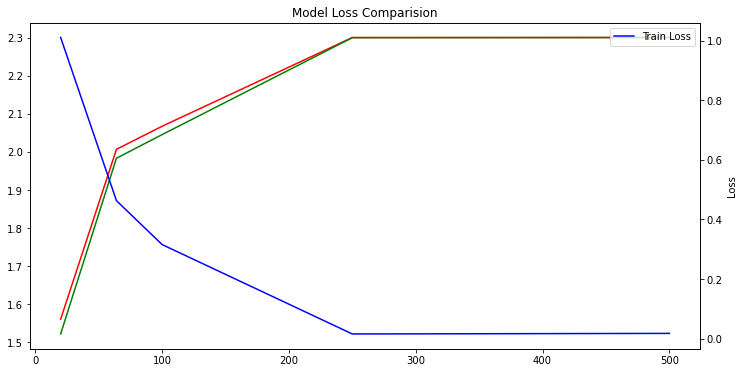

In [41]:
plt.figure(figsize=(12,6))
print(len(trainloss_list))
plt.plot(batch_size, trainloss_list, color = "r")
plt.plot(batch_size, testloss_list, color = "g")
ax2 = plt.twinx()
plt.plot(batch_size, sensitivity_list, color = "b")
plt.title('Model Loss Comparision')
plt.legend(['Train Loss', 'Test Loss', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

5


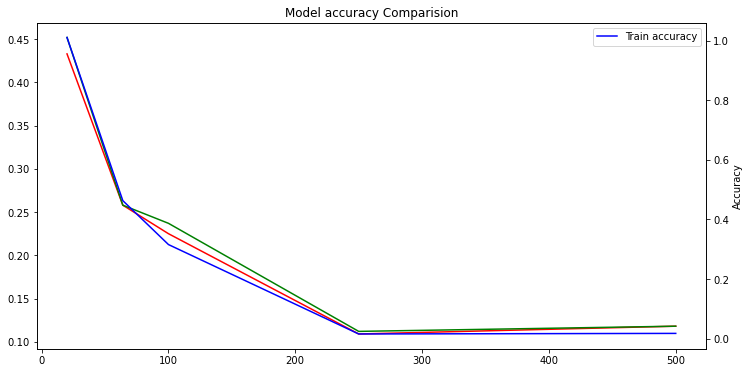

In [42]:
plt.figure(figsize=(12,6))
print(len(trainacc_list))
plt.plot(batch_size, trainacc_list, color = "r")
plt.plot(batch_size, testacc_list, color = "g")
ax2 = plt.twinx()
plt.plot(batch_size, sensitivity_list, color = "b")
plt.title('Model accuracy Comparision')
plt.legend(['Train accuracy', 'Test accuracy', 'Sensitivity'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()